# Linear Model Using Pytorch

With the blue cube to the left, load:

python/3.8.5-fasrc01

cuda/11.1.0-fasrc01

In [97]:
# import os

# os.chdir("/n/dominici_nsaph_l3/Lab/projects/heat-alerts_mortality_RL")

! python ~/Q_prep.py

In [100]:
## Set up the model

class LM(nn.Module):

    def __init__(self, n_col) -> None:
        super().__init__() # create parent object; always start with this line
        self.lm1 = nn.Linear(in_features = n_col, out_features = 2) # returning Q0 and Q1

    def forward(self, x):
        return self.lm1(x)


In [99]:
## Methods to evaluate the model

def eval_Q(Q_model, S, over = None): 

    Q = Q_model(S) # n x 2

    best_Q = torch.amax(Q, axis = 1) # n 

    if over is not None:
        final_Q = torch.where(over, Q[:,0], best_Q) # n
        return final_Q

    return best_Q


In [110]:
# S = pd.concat([S, S_OHE], axis = 1)
# S_1 = pd.concat([S_1, S1_OHE], axis = 1)
# A = Train["alert"].drop(n_seq_s)
# R = -1*(Train["N"]*100000/Train["Pop.65"]).drop(n_seq_s)
# ep_end = Train["dos"].drop(n_seq_s) == 152
# over = over_budget["over_budget"] == 1

In [111]:
## Set up dataloader
data = [S, A, R, S_1, ep_end, over]

dev = "cpu"
tensors = [torch.from_numpy(v.to_numpy()).to(dev) for v in data]

DS = TensorDataset(*tensors)

torch.manual_seed(321)

DL = DataLoader(DS, batch_size = 256, shuffle = True, pin_memory = True)

In [124]:
## Initialize the model

state_dim = S.shape[1]
num_episodes = n_counties*n_years
# print(num_episodes)
n = num_episodes*(n_days-1)

model = LM(state_dim)
model = model.to(dev)

# optimizer = optim.Adam(model.parameters(), lr = 0.0001, betas=(0.25, 0.99))
optimizer = optim.SGD(model.parameters(), lr = 0.01, momentum=0.25)

update_tgt_every = 50
print_every = 10
tgt_model = deepcopy(model)


In [126]:
## Train

epochs = 1000

epoch_loss_means = []
for k in range(1, epochs):
    l = []
    iter = 1
    for s, a, r, s1, e, over in tqdm(DL, disable=True):
        with torch.no_grad():
            target = r + gamma*(1-e.float())*eval_Q(tgt_model, s1.float(), over)

        optimizer.zero_grad()

        output = model(s.float()) # n x 2
        q0 = output[:,0]
        q1 = output[:,1]
        Q = (1-a)*q0 + (a)*q1

        # loss = F.mse_loss(Q, target)
        loss = F.smooth_l1_loss(Q, target)  # huber loss as in DQN paper

        loss.backward()
        optimizer.step()
        l.append(loss.item())
        
        iter+=1
        if iter == 100:
            break
    
    epoch_loss = np.mean(l)
    epoch_loss_means.append(epoch_loss)
    if k % print_every == 0:
        print(f"Epoch: {k}, average loss: {epoch_loss:.4f}")

    if k % update_tgt_every == 0:
        tgt_model = deepcopy(model)


Epoch: 10, average loss: 4724728837.9891
Epoch: 20, average loss: 5542307307.5387
Epoch: 30, average loss: 4151222931.0307
Epoch: 40, average loss: 4005975831.1364
Epoch: 50, average loss: 3867103254.4621
Epoch: 60, average loss: 4545562254.6225
Epoch: 70, average loss: 4443974867.3666
Epoch: 80, average loss: 4449320315.3674
Epoch: 90, average loss: 4490840242.6070
Epoch: 100, average loss: 4537398073.0068
Epoch: 110, average loss: 4647731596.8625
Epoch: 120, average loss: 4566985153.0555
Epoch: 130, average loss: 4580853761.0167
Epoch: 140, average loss: 4626488115.6801
Epoch: 150, average loss: 4605612298.9862
Epoch: 160, average loss: 3982370688.5375
Epoch: 170, average loss: 3791969014.1553
Epoch: 180, average loss: 3948942520.9745
Epoch: 190, average loss: 3836193753.7231
Epoch: 200, average loss: 3868277784.2960
Epoch: 210, average loss: 4036362739.7070
Epoch: 220, average loss: 4055888723.9326
Epoch: 230, average loss: 3977848129.7364
Epoch: 240, average loss: 4045788831.4896
E

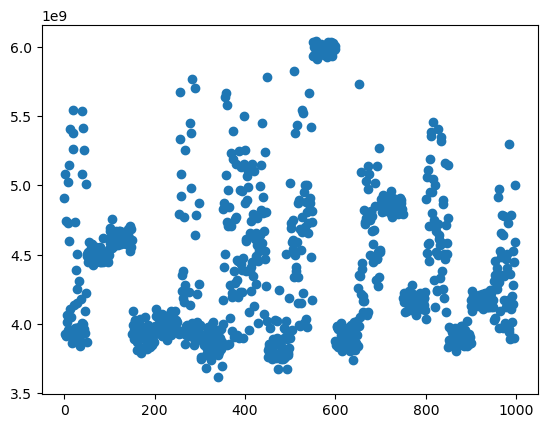

In [127]:
plt.scatter(range(len(epoch_loss_means)), epoch_loss_means)
plt.show()